In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

import transformers

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import FuncFormatter


In [2]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'
# bigger size
mpl.rcParams['font.size'] = 14

In [3]:
from src.BBPE_flores import build_gpt_tokenizer
from src.utils import hex_to_str, str_to_hex

## Load FLORES dataset

In [4]:
# load flores dataset for languages: en, es, pt, fr, it, ro, pl, mt, ja, zh, ko, te, ta
languages = ['en', 'es', 'pt', 'fr', 'it', 'ro', 'pl', 'mt','he', 'ar', 'ja', 'ko', 'te', 'ta', 'si']

palette = sns.color_palette("viridis", len(languages))
languages_colors = {lang: col for lang, col in zip(languages, palette)}
nice_colors = [ ]
languages_flores = {'en': 'eng_Latn',
                    'es': 'spa_Latn',
                    'pt': 'por_Latn',
                    'fr': 'fra_Latn',
                    'it': 'ita_Latn',
                    'ro': 'ron_Latn',
                    'pl': 'pol_Latn',
                    'mt': 'mlt_Latn',
                    'he': 'heb_Hebr',
                    'ar': 'arb_Arab',
                    'ja': 'jpn_Jpan',
                    #'zh': 'zho_Hans',
                    'ko': 'kor_Hang',
                    'te': 'tel_Telu',
                    'ta': 'tam_Taml',
                    #'bo': 'bod_Tibt',
                    'si': 'sin_Sinh'}
flores = {}

for lang in languages:
    with open(f'flores200_dataset/devtest/{languages_flores[lang]}.devtest', 'r') as f:
        flores[lang] = f.read().splitlines()

In [5]:
flores_chars = flores.copy()
flores_bytes = {lang: [bytes(line, 'utf-8') for line in flores[lang]] for lang in flores.keys()}
flores_words = {lang: [line.split() for line in flores[lang]] for lang in flores.keys()}


In [6]:
# XLM-R tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("xlm-roberta-base")
flores_xlmr = {lang: [tokenizer.encode(line) for line in flores[lang]] for lang in flores.keys()}

## Plot the number of tokens per language

In [7]:
def plot_token_numbers(lang_tokenized, title=None):
    token_numbers = {}
    for lang in lang_tokenized.keys():
        token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
    # sort by value
    token_numbers = dict(sorted(token_numbers.items(), key=lambda item: item[1], reverse=True))
    plt.bar(token_numbers.keys(), token_numbers.values())
    for i, lang in enumerate(token_numbers.keys()):
        plt.bar(i, token_numbers[lang], color=languages_colors[lang])
    #plt.xticks(rotation=90)
    plt.ylabel("Line avg.")
    if title:
        plt.title(title)
    plt.show()

In [8]:
def plot_compare_token_numbers(lang_tokenized_methods, method_names, title=None, parity=None):
   
    assert len(lang_tokenized_methods) == len(method_names)
    token_number_methods = {}
    for lang_tokenized, method in zip(lang_tokenized_methods, method_names):
        token_numbers = {}
        for lang in lang_tokenized.keys():
            token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
        token_number_methods[method] = token_numbers

    
    token_number_methods = pd.DataFrame(token_number_methods)
    if parity and parity in token_number_methods.index:
        token_number_methods = token_number_methods / token_number_methods.loc[parity,:]
    print(token_number_methods)
    # compute mean and std
    print(f"Means: {token_number_methods.mean(axis=0)}")
    print(f"Std: {token_number_methods.std(axis=0)}")

    sns.set_palette(['#B2DF8A', '#FDBF6F', '#B3CDE3', '#FCCDE5', '#D9D9D9'])

    sns.boxplot(data=token_number_methods)
    #plt.boxplot(token_number_methods, labels=method_names)
    plt.xticks(rotation=45)
    if parity:
        plt.ylabel(f"Parity to {parity}")
    else:
        plt.ylabel("Line avg. segemnets (log)")
        plt.semilogy()
    if title:
        plt.title(title)
    plt.show()

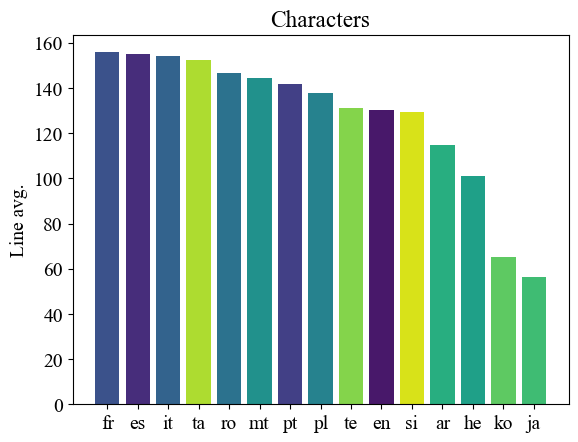

In [9]:
plot_token_numbers(flores_chars, "Characters")

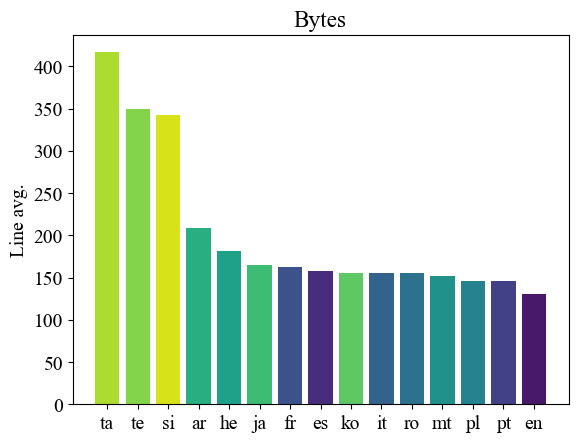

In [10]:
plot_token_numbers(flores_bytes, "Bytes")

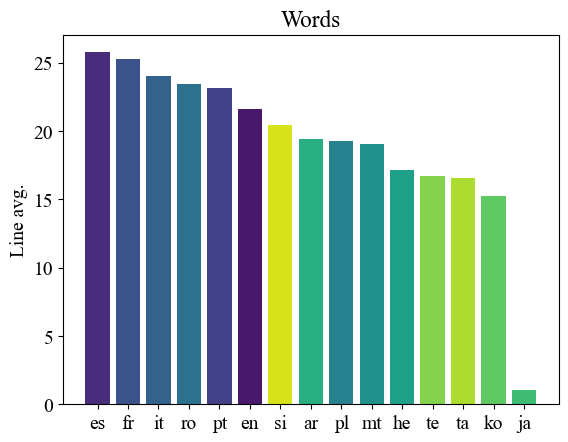

In [11]:
plot_token_numbers(flores_words, "Words")

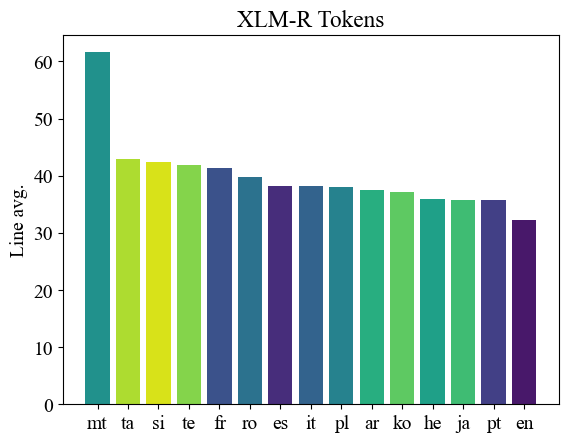

In [12]:
plot_token_numbers(flores_xlmr, "XLM-R Tokens")

## Balenced BBPE on FLORES

In [13]:
split="dev"
flores_tokenizers = build_gpt_tokenizer(f"flores200_dataset/{split}/joint.{split}", [10000, 50000,100000])
flores_il_tokenizers = {}
for lang in languages:
    flores_il_tokenizers[lang] = build_gpt_tokenizer(f"flores200_dataset/{split}/{languages_flores[lang]}.{split}", [2000, 10000,20000])


In [14]:
flores_baltok = {lang: [flores_tokenizers['tokenizer_50000'].encode(line) for line in flores[lang]] for lang in flores.keys()}
flores_il_baltok = {lang: [flores_il_tokenizers[lang]['tokenizer_10000'].encode(line) for line in flores[lang]] for lang in flores.keys()}

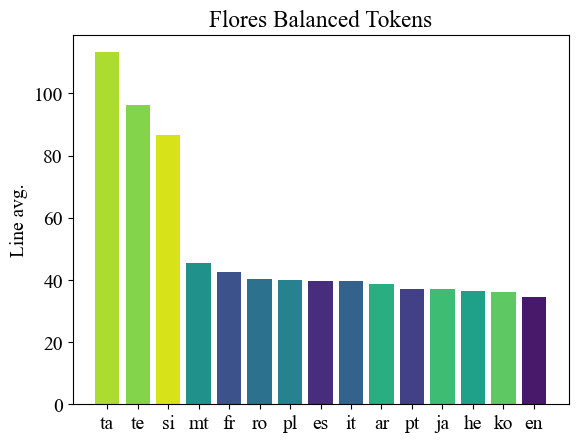

In [15]:
plot_token_numbers(flores_baltok, "Flores Balanced Tokens")

## Morfessor rewriting

In [17]:
from src.rewrite_bytes import ByteRewriter
from src.utils import str_to_hex

In [22]:
decompose_file = "byte_maps/decompose.json"
morf_map_file = "byte_maps/morf_map_decomposed_filtered_cost_clustered.json"
morf_all_map_file = "byte_maps/morf_map_all_cost_clustered8.json"
decompose_rewriter = ByteRewriter(decompose_file)
morf_rewriter = ByteRewriter(morf_map_file)
morf_all_rewriter = ByteRewriter(morf_all_map_file)

flores_decomposed_rw = {lang: [decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' ')) for line in flores[lang]] for lang in flores.keys()}
flores_morfs_rw = {lang: [morf_rewriter.rewrite_bytes(decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' '))) for line in flores[lang]] for lang in flores.keys()}
flores_morfs_all_rw = {lang: [morf_all_rewriter.rewrite_bytes(decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' '))) for line in flores[lang]] for lang in flores.keys()}

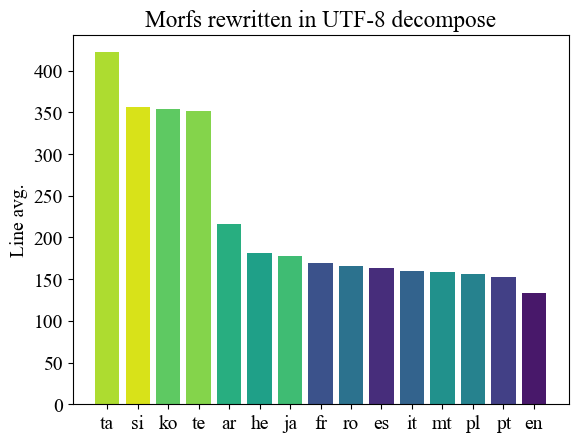

In [23]:
title = f"Morfs rewritten in UTF-8 decompose"
plot_token_numbers(flores_decomposed_rw , title)

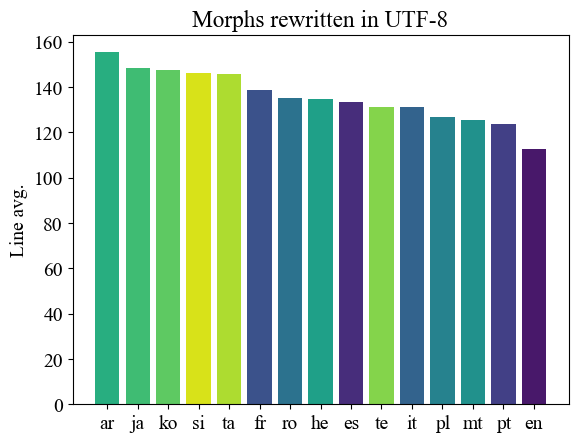

In [24]:
title = f"Morphs rewritten in UTF-8"
plot_token_numbers(flores_morfs_rw , title)

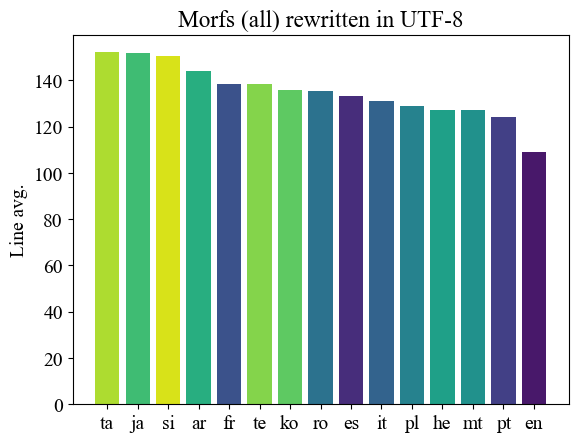

In [25]:
title = f"Morfs (all) rewritten in UTF-8"
plot_token_numbers(flores_morfs_all_rw , title)

## Compare Parity

         bytes    m. bytes  m. bytes (all)       chars
en  130.529644  112.779644      109.145257  130.401186
es  158.046443  133.501976      133.414032  155.178854
pt  145.769763  123.430830      123.992095  141.787549
fr  162.081028  138.798419      138.574111  155.818182
it  155.394269  131.163043      130.907115  154.286561
ro  155.099802  135.287549      135.332016  146.844862
pl  146.495059  126.517787      129.009881  137.831028
mt  151.973320  125.385375      127.179842  144.553360
he  180.910079  134.723320      127.296443  100.843874
ar  208.770751  155.281621      144.226285  114.940711
ja  165.127470  148.534585      152.018775   56.267787
ko  155.927866  147.501976      135.702569   65.182806
te  349.516798  131.336957      138.233202  130.933794
ta  416.641304  145.497036      152.125494  152.305336
si  341.952569  146.229249      150.630435  129.525692
Means: bytes             201.615744
m. bytes          135.731291
m. bytes (all)    135.185837
chars             127.7801

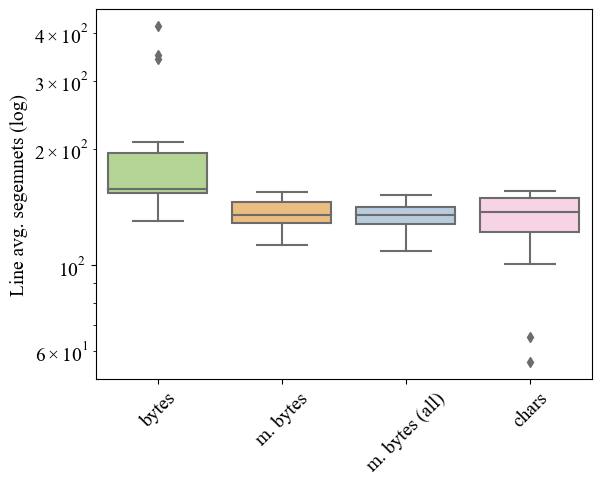

In [26]:

plot_compare_token_numbers([flores_bytes, flores_morfs_rw, flores_morfs_all_rw, flores_chars],
                           ['bytes','m. bytes','m. bytes (all)','chars'])

       bytes  m. bytes  m. bytes (all)     chars
en  1.000000  1.000000        1.000000  1.000000
es  1.210809  1.183742        1.222353  1.190011
pt  1.116756  1.094442        1.136028  1.087318
fr  1.241718  1.230705        1.269630  1.194914
it  1.190490  1.163003        1.199384  1.183168
ro  1.188234  1.199574        1.239926  1.126101
pl  1.122313  1.121814        1.182002  1.056977
mt  1.164282  1.111773        1.165235  1.108528
he  1.385969  1.194571        1.166303  0.773336
ar  1.599413  1.376859        1.321416  0.881439
ja  1.265057  1.317034        1.392812  0.431498
ko  1.194578  1.307878        1.243321  0.499864
te  2.677681  1.164545        1.266507  1.004084
ta  3.191929  1.290100        1.393789  1.167975
si  2.619731  1.296593        1.380091  0.993286
Means: bytes             1.544597
m. bytes          1.203509
m. bytes (all)    1.238586
chars             0.979900
dtype: float64
Std: bytes             0.688707
m. bytes          0.100988
m. bytes (all)    0.106762


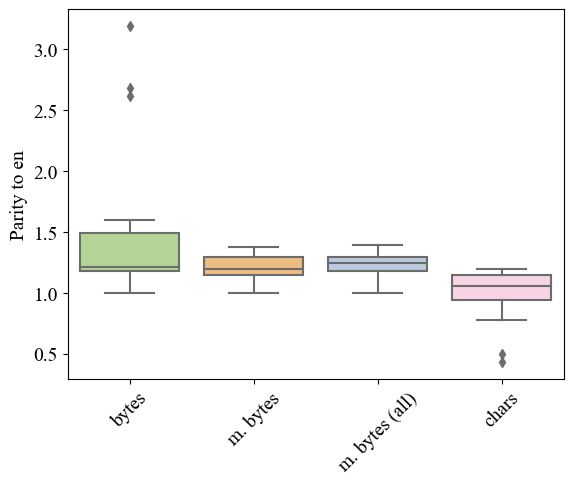

In [27]:
plot_compare_token_numbers([flores_bytes, flores_morfs_rw, flores_morfs_all_rw, flores_chars],
                           ['bytes','m. bytes','m. bytes (all)','chars'], parity='en')

In [28]:
compression_factors = []
for lang in languages:
    byte_base = sum([len(sen) for sen in flores_bytes[lang]])
    morph_base = sum([len(sen) for sen in flores_morfs_all_rw[lang]])
    compression_factors.append(1- (morph_base/byte_base))

In [29]:
sum(compression_factors) / len(compression_factors)

0.2530091933487367

In [30]:
sorted_languages, compression_factors = zip(*sorted(zip(languages, compression_factors), key=lambda item: item[1], reverse=True))

In [31]:
max(compression_factors)

0.6348765893259907

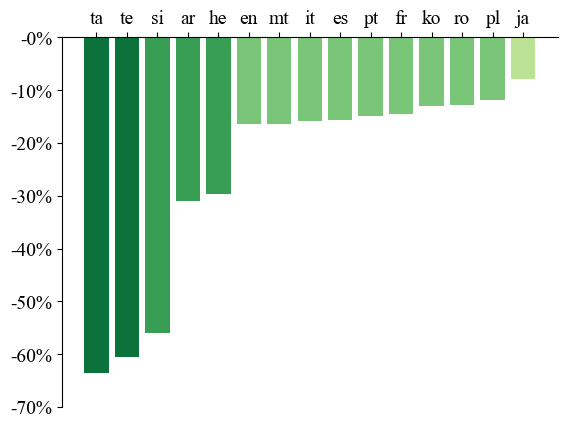

In [32]:
# plot bar plot going down from 0 to 100 %

# barplot with pall

def percent_minus_formatter(x, pos):
    return f"-{x:.0f}%"

cmap = plt.cm.get_cmap('YlGn')
norm = BoundaryNorm([-0.1, 0.01, 0.05, 0.1, 0.2,  0.6, 0.7, 0.8], cmap.N)


plt.bar(sorted_languages, np.array(compression_factors) * 100, color=cmap(norm(compression_factors)))


ax = plt.gca()
formatter = FuncFormatter(percent_minus_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params('x', top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_ylim([0.,70.])
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# add percent to y ticks


ax.invert_yaxis()




plt.show()

In [127]:
compression_factors 

(0.6507858581115213,
 0.6242327776065771,
 0.5723697898606006,
 0.25620988659383936,
 0.255302297890005,
 0.17495139697133233,
 0.15593384162432677,
 0.15529907529557407,
 0.1532480561825934,
 0.14364795825052123,
 0.13636823538140885,
 0.13598443556201545,
 0.12773873764820565,
 0.10048531198199973,
 0.054037097826982405)

In [ ]:
# barplot with palette green


In [123]:
cmap.N

256